In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

## Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    
    # For MAM, T_conns is divided into T_network_global and T_connect:
    if 'T_conns_min' not in list(df) and 'T_network_global_min' in list(df): 
        df['T_conns_min'] = df['T_network_global_min'] + df['T_connect_min']
        df['T_conns_max'] = df['T_network_global_max'] + df['T_connect_max']
    
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [6]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [7]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [8]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar', title=''):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    if title:
        fig.suptitle(title, y=1.2)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

## Benchmarks with weak scaling

### HPC Benchmark

In [23]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)

test = calculate_T_conn_and_memory(hpc_220)
test['git'] = '2.20'
rename_d = {'NUMBER_OF_NODES': 'NUM_NODES', 'TASKS_PER_NODE': 'TASKS/NODE', 'THREADS_PER_TASK': 'THREADS/TASK'}

test_n = test.rename(columns=rename_d, inplace=False)

test_n

,git,NUM_NODES,TASKS/NODE,THREADS/TASK,num_tasks,NUM_VPS,SCALE,PLASTIC,T_nrns,T_conns_min,...,T_bld_xn,T_bld_nx,Conn. Total,Conn. Creation (min),Conn. Exchange (min),N_VP,connections,ini,other,Memory per VP
0,2.20,1,6,6,6,36,20,True,0.46,47.47,...,100.93,100.88,100.88,47.47,51.06,36,2.739827,0.019534,0.059720,2.819082
1,2.20,2,6,6,12,72,40,True,0.46,47.47,...,106.29,106.31,106.29,47.47,54.56,72,2.739827,0.025231,0.069769,2.834828
2,2.20,4,6,6,24,144,80,True,0.48,47.41,...,108.38,108.40,108.38,47.41,56.86,144,2.739827,0.108971,0.059372,2.908171
3,2.20,8,6,6,48,288,160,True,0.62,47.67,...,113.49,113.52,113.49,47.67,63.50,288,2.739827,0.114269,0.059384,2.913480
4,2.20,16,6,6,96,576,320,True,0.62,47.48,...,131.91,131.74,131.74,47.48,79.77,576,2.739827,0.250336,0.061474,3.051638
5,2.20,32,6,6,192,1152,640,True,0.62,47.59,...,159.99,159.98,159.98,47.59,108.10,1152,2.739827,0.595388,0.060439,3.395655


Conn. Creation (min)                                                  \
Case            NEST 2.20 NEST 3.0 (47a9175e4) - old NEST 3.0 (a641eec1e)   
N_VP                                                                        
36                  47.47                      52.68                56.66   
72                  47.47                      52.80                56.59   
144                 47.41                      52.77                57.06   
288                 47.67                      53.44                57.37   
576                 47.48                      54.17                58.23   
1152                47.59                      55.57                  NaN   

                                Conn. Exchange (min)  \
Case NEST 3.0 (d4d1b3f5 inline)            NEST 2.20   
N_VP                                                   
36                        56.64                51.06   
72                        56.59                54.56   
144                       56.99                56.86   
288                       57.39                63.50   
576                       58.31                79.77   
1152                      59.56               108.10   

                                                      \
Case NEST 3.0 (47a9175e4) - old NEST 3.0 (a641eec1e)   
N_VP                                                   
36                        53.02                77.80   
72                        57.50                80.93   
144                       59.03                80.88   
288                       65.41                85.66   
576                       82.21                89.80   
1152                     108.27                  NaN   

                                Conn. Total                             \
Case NEST 3.0 (d4d1b3f5 inline)   NEST 2.20 NEST 3.0 (47a9175e4) - old   
N_VP                                                                     
36                        70.85      100.88                     110.49   
72                        72.93      106.29                     114.68   
144                       73.53      108.38                     117.41   
288                       75.74      113.49                     125.03   
576                       80.57      131.74                     142.93   
1152                      84.28      159.98                     170.28   

                                                     Memory per VP  \
Case NEST 3.0 (a641eec1e) NEST 3.0 (d4d1b3f5 inline)     NEST 2.20   
N_VP                                                                 
36                 145.19                     135.37      2.819082   
72                 150.17                     144.54      2.834828   
144                149.15                     142.81      2.908171   
288                156.76                     148.18      2.913480   
576                161.55                     153.53      3.051638   
1152                  NaN                     159.50      3.395655   

                                                      \
Case NEST 3.0 (47a9175e4) - old NEST 3.0 (a641eec1e)   
N_VP                                                   
36                     2.809872             2.890740   
72                     2.819189             2.893303   
144                    2.901932             2.980969   
288                    2.906122             2.983796   
576                    3.041696             3.068073   
1152                   3.374836                  NaN   

                                Simulation time                             \
Case NEST 3.0 (d4d1b3f5 inline)       NEST 2.20 NEST 3.0 (47a9175e4) - old   
N_VP                                                                         
36                     2.887042          191.81                     199.86   
72                     2.894650          199.87                     205.66   
144                    2.981258          199.12                     210.67   
288                    2.98599

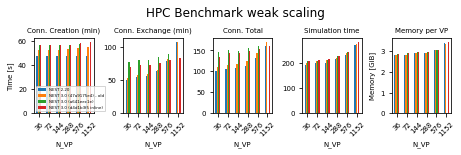

In [17]:
hpc_220 = pd.read_csv('results/hpc_benchmark_2_20_daint.csv')
hpc_220['Case'] = ['NEST 2.20'] * len(hpc_220)
#hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_177126d6c_daint.csv')
#hpc_3['Case'] = ['NEST 3.0 (177126d6c)'] * len(hpc_3)

hpc_3_inline = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_inline_daint.csv')
hpc_3_inline['Case'] = ['NEST 3.0 (d4d1b3f5 inline)'] * len(hpc_3_inline)
#hpc_3_d4 = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_daint.csv')
#hpc_3_d4['Case'] = ['NEST 3.0 (d4d1b3f5)'] * len(hpc_3_d4)

hpc_3_a6 = pd.read_csv('results/hpc_benchmark_3_0_a641eec1e_daint.csv')
hpc_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(hpc_3_a6)

hpc_3_old = pd.read_csv('results/hpc_benchmark_3_0_47a9175e4_daint.csv')
hpc_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(hpc_3_old)

hpc = pd.concat([hpc_220, hpc_3_inline, hpc_3_old, hpc_3_a6])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left',
                     title='HPC Benchmark weak scaling')

# hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.svg', legend_loc='lower left',
#                      title='HPC Benchmark weak scaling')

hpc_p

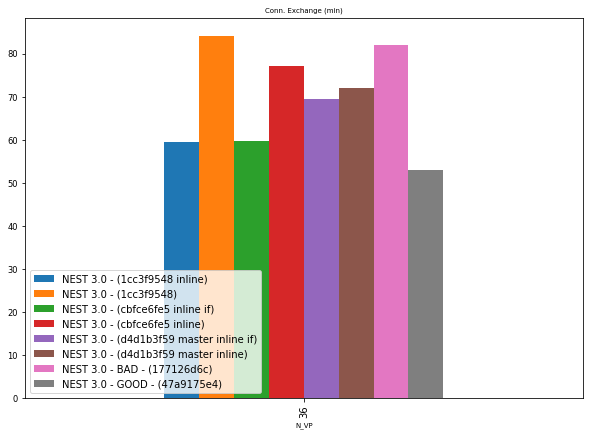

In [15]:
hpc_3_good = pd.read_csv('results/hpc_benchmark_3_0_47a9175e4_daint.csv')
hpc_3_good['Case'] = ['NEST 3.0 - GOOD - (47a9175e4)'] * len(hpc_3_good)
hpc_3_good = hpc_3_good[hpc_3_good['NUMBER_OF_NODES']==1]

hpc_3_bad = pd.read_csv('results/hpc_benchmark_3_0_177126d6c_daint.csv')
hpc_3_bad['Case'] = ['NEST 3.0 - BAD - (177126d6c)'] * len(hpc_3_bad)
hpc_3_bad = hpc_3_bad[hpc_3_bad['NUMBER_OF_NODES']==1]

# hpc_3_boost= pd.read_csv('results/hpc_benchmark_3_0_cf7d6a8c9_boost_daint.csv')
# hpc_3_boost['Case'] = ['NEST 3.0 - Boost - (cf7d6a8c9)'] * len(hpc_3_boost)
# hpc_3_boost = hpc_3_boost[hpc_3_boost['NUMBER_OF_NODES']==1]

# hpc_3_33= pd.read_csv('results/hpc_benchmark_bisect_33870e6e2_daint.csv')
# hpc_3_33['Case'] = ['NEST 3.0 - merge - (33870e6e2)'] * len(hpc_3_33)

# hpc_3_cb= pd.read_csv('results/hpc_benchmark_bisect_cbfce6fe5_daint.csv')
# hpc_3_cb['Case'] = ['NEST 3.0 - (cbfce6fe5)'] * len(hpc_3_cb)

# hpc_3_1c= pd.read_csv('results/hpc_benchmark_bisect_1c231dab9_daint.csv')
# hpc_3_1c['Case'] = ['NEST 3.0 - (1c231dab9)'] * len(hpc_3_1c)

# hpc_3_d6= pd.read_csv('results/hpc_benchmark_bisect_d6435f354_daint.csv')
# hpc_3_d6['Case'] = ['NEST 3.0 - (d6435f354)'] * len(hpc_3_d6)

# hpc_3_32= pd.read_csv('results/hpc_benchmark_bisect_3237156e_daint.csv')
# hpc_3_32['Case'] = ['NEST 3.0 - (3237156e)'] * len(hpc_3_32)

# hpc_3_d0= pd.read_csv('results/hpc_benchmark_bisect_d0b38d88b_daint.csv')
# hpc_3_d0['Case'] = ['NEST 3.0 - (d0b38d88b)'] * len(hpc_3_d0)

# hpc_3_1cb= pd.read_csv('results/hpc_benchmark_bisect_1cb45ca5a_daint.csv')
# hpc_3_1cb['Case'] = ['NEST 3.0 - (1cb45ca5a)'] * len(hpc_3_1cb)

# hpc_3_94= pd.read_csv('results/hpc_benchmark_bisect_9404d57a9_daint.csv')
# hpc_3_94['Case'] = ['NEST 3.0 - (9404d57a9)'] * len(hpc_3_94)

# hpc_3_94= pd.read_csv('results/hpc_benchmark_bisect_9404d57a9_daint.csv')
# hpc_3_94['Case'] = ['NEST 3.0 - (9404d57a9)'] * len(hpc_3_94)

# hpc_3_10_omp = pd.read_csv('results/hpc_benchmark_bisect_10ad3af02_omp_daint.csv')
# hpc_3_10_omp['Case'] = ['NEST 3.0 - omp - (10ad3af02)'] * len(hpc_3_10_omp)

# hpc_3_10 = pd.read_csv('results/hpc_benchmark_bisect_10ad3af02_daint.csv')
# hpc_3_10['Case'] = ['NEST 3.0 - m - (10ad3af02)'] * len(hpc_3_10)

# hpc_3_07_in = pd.read_csv('results/hpc_benchmark_3_0_07d2acc42_inline_daint.csv')
# hpc_3_07_in['Case'] = ['NEST 3.0 - m - (07d2acc42 inline)'] * len(hpc_3_07_in)

#---------------------------------------------------------------------------------------

# hpc_3_1f = pd.read_csv('results/hpc_benchmark_3_0_1fd027118_daint.csv')
# hpc_3_1f['Case'] = ['NEST 3.0 - 0 (1fd027118)'] * len(hpc_3_1f)

# hpc_3_d3 = pd.read_csv('results/hpc_benchmark_bisect_d3237156e_daint.csv')
# hpc_3_d3['Case'] = ['NEST 3.0 - 1 (d3237156)'] * len(hpc_3_d3)

# hpc_3_d3_i = pd.read_csv('results/hpc_benchmark_bisect_d3237156_inline_daint.csv')
# hpc_3_d3_i['Case'] = ['NEST 3.0 - 1 (d3237156 inline )'] * len(hpc_3_d3_i)

# hpc_3_d3_test = pd.read_csv('results/hpc_benchmark_3_0_d3237156e_test_daint.csv')
# hpc_3_d3_test['Case'] = ['NEST 3.0 - 1 (d3237156 inline test)'] * len(hpc_3_d3_test)

# hpc_3_db_in = pd.read_csv('results/hpc_benchmark_3_0_db44655ff_inline_daint.csv')
# hpc_3_db_in['Case'] = ['NEST 3.0 - 2 (db44655ff inline)'] * len(hpc_3_db_in)

# hpc_3_7d_in = pd.read_csv('results/hpc_benchmark_3_0_7dfa9f436_inline_daint.csv')
# hpc_3_7d_in['Case'] = ['NEST 3.0 - 3 (7dfa9f436 inline)'] * len(hpc_3_7d_in)

# hpc_3_0b = pd.read_csv('results/hpc_benchmark_3_0_0bd571945_daint.csv')
# hpc_3_0b['Case'] = ['NEST 3.0 - 4 (0bd571945)'] * len(hpc_3_0b)

# hpc_3_0b_in = pd.read_csv('results/hpc_benchmark_3_0_0bd571945_inline_daint.csv')
# hpc_3_0b_in['Case'] = ['NEST 3.0 - 4 (0bd571945 inline)'] * len(hpc_3_0b_in)

# hpc_3_0b_fin = pd.read_csv('results/hpc_benchmark_3_0_0bd571945_forceinline_daint.csv')
# hpc_3_0b_fin['Case'] = ['NEST 3.0 - 4 (0bd571945 forceinline)'] * len(hpc_3_0b_fin)

# hpc_3_0b_in_t = pd.read_csv('results/hpc_benchmark_3_0_0bd571945_inline_test_daint.csv')
# hpc_3_0b_in_t['Case'] = ['NEST 3.0 - 4 (0bd571945 inline test)'] * len(hpc_3_0b_in_t)

# hpc_3_b5_in = pd.read_csv('results/hpc_benchmark_3_0_b59bb92fe_inline_daint.csv')
# hpc_3_b5_in['Case'] = ['NEST 3.0 - 4a (b59bb92fe inline)'] * len(hpc_3_b5_in)

# hpc_3_1c_in = pd.read_csv('results/hpc_benchmark_3_0_1cc3f9548_inline_daint.csv')
# hpc_3_1c_in['Case'] = ['NEST 3.0 - 4b (1cc3f9548 inline)'] * len(hpc_3_1c_in)

# hpc_3_cb_in = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_daint.csv')
# hpc_3_cb_in['Case'] = ['NEST 3.0 - 4c (cbfce6fe5 inline)'] * len(hpc_3_cb_in)

# hpc_3_cb = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_daint.csv')
# hpc_3_cb['Case'] = ['NEST 3.0 - 4c (cbfce6fe5)'] * len(hpc_3_cb)

# hpc_3_cb_in_if = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_if_daint.csv')
# hpc_3_cb_in_if['Case'] = ['NEST 3.0 - 4c (cbfce6fe5 inline if)'] * len(hpc_3_cb_in_if)

# hpc_3_cb_in_if2 = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_if2_daint.csv')
# hpc_3_cb_in_if2['Case'] = ['NEST 3.0 - 4c (cbfce6fe5 inline if2)'] * len(hpc_3_cb_in_if2)

# hpc_3_02_in = pd.read_csv('results/hpc_benchmark_3_0_025cab8b0_inline_daint.csv')
# hpc_3_02_in['Case'] = ['NEST 3.0 - 5 (025cab8b0 inline)'] * len(hpc_3_02_in)

# hpc_3_1a_in = pd.read_csv('results/hpc_benchmark_3_0_1acc8ad77_inline_daint.csv')
# hpc_3_1a_in['Case'] = ['NEST 3.0 - 6 (1acc8ad77 inline)'] * len(hpc_3_1a_in)

hpc_3_1c = pd.read_csv('results/hpc_benchmark_3_0_1cc3f9548_daint.csv')
hpc_3_1c['Case'] = ['NEST 3.0 - (1cc3f9548)'] * len(hpc_3_1c)

hpc_3_1c_in = pd.read_csv('results/hpc_benchmark_3_0_1cc3f9548_inline_daint.csv')
hpc_3_1c_in['Case'] = ['NEST 3.0 - (1cc3f9548 inline)'] * len(hpc_3_1c_in)

hpc_3_cb_in = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_daint.csv')
hpc_3_cb_in['Case'] = ['NEST 3.0 - (cbfce6fe5 inline)'] * len(hpc_3_cb_in)

hpc_3_cb_in_if = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_if_daint.csv')
hpc_3_cb_in_if['Case'] = ['NEST 3.0 - (cbfce6fe5 inline if)'] * len(hpc_3_cb_in_if)

hpc_3_cb_in_if2 = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_if2_daint.csv')
hpc_3_cb_in_if2['Case'] = ['NEST 3.0 - (cbfce6fe5 inline if2)'] * len(hpc_3_cb_in_if2)

hpc_3_cb_in_nod = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_nodebugg_daint.csv')
hpc_3_cb_in_nod['Case'] = ['NEST 3.0 - (cbfce6fe5 inline no debugg)'] * len(hpc_3_cb_in_nod)

hpc_3_cb_in_nod_02 = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_nodebugg_02_daint.csv')
hpc_3_cb_in_nod_02['Case'] = ['NEST 3.0 - (cbfce6fe5 inline no debugg 02)'] * len(hpc_3_cb_in_nod_02)

hpc_3_cb_in_gsl = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_gsl_daint.csv')
hpc_3_cb_in_gsl['Case'] = ['NEST 3.0 - (cbfce6fe5 inline gsl)'] * len(hpc_3_cb_in_gsl)

hpc_3_cb_in_not_strict = pd.read_csv('results/hpc_benchmark_3_0_cbfce6fe5_inline_not_strict_daint.csv')
hpc_3_cb_in_not_strict['Case'] = ['NEST 3.0 - (cbfce6fe5 inline not strict)'] * len(hpc_3_cb_in_not_strict)

hpc_3_d4_in = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_inline_daint.csv')
hpc_3_d4_in['Case'] = ['NEST 3.0 - (d4d1b3f59 master inline)'] * len(hpc_3_d4_in)

hpc_3_d4_in_if = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_inline_if_daint.csv')
hpc_3_d4_in_if['Case'] = ['NEST 3.0 - (d4d1b3f59 master inline if)'] * len(hpc_3_d4_in_if)

hpc_bisect = pd.concat([hpc_3_good, hpc_3_bad,
                        hpc_3_1c, hpc_3_1c_in,
                        hpc_3_cb_in, hpc_3_cb_in_if,# hpc_3_cb_in_if2, hpc_3_cb_in_nod, hpc_3_cb_in_nod_02,
                        #hpc_3_cb_in_gsl, hpc_3_cb_in_not_strict,
                        hpc_3_d4_in_if, hpc_3_d4_in])
hpc_bisect = calculate_T_conn_and_memory(hpc_bisect)

hpc_bisect_p = pd.pivot_table(hpc_bisect, index='N_VP', columns='Case', values=['Conn. Exchange (min)'])
ax = hpc_bisect_p['Conn. Exchange (min)'].plot(kind='bar', title='Conn. Exchange (min)', figsize=(10,7)).legend(loc="lower left")

### HPC - `fixed_outdegree`

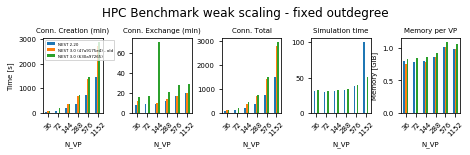

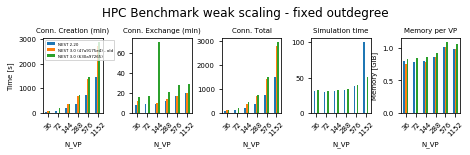

In [54]:
hpc_2_20_out = pd.read_csv('results/hpc_benchmark_2_20_37722d5e3_daint_out.csv')
hpc_2_20_out['Case'] = ['NEST 2.20']*len(hpc_2_20_out)

hpc_3_out = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_out.csv')
hpc_3_out['Case'] = ['NEST 3.0 (630a97265)']*len(hpc_3_out)

hpc_3_out_old = pd.read_csv('results/hpc_benchmark_3_0_47a9175e4_daint_out.csv')
hpc_3_out_old['Case'] = ['NEST 3.0 (47a9175e4) - old']*len(hpc_3_out_old)

hpc_out = pd.concat([hpc_2_20_out, hpc_3_out, hpc_3_out_old])

hpc_out = calculate_T_conn_and_memory(hpc_out)
hpc_out_p = plot_compare(hpc_out, 'figures/hpc_benchmark_weak_scaling_out.pdf', legend_loc='upper left',
                         title='HPC Benchmark weak scaling - fixed outdegree')

hpc_out_p = plot_compare(hpc_out, 'figures/hpc_benchmark_weak_scaling_out.svg', legend_loc='upper left',
                         title='HPC Benchmark weak scaling - fixed outdegree')

### HPC - Rules

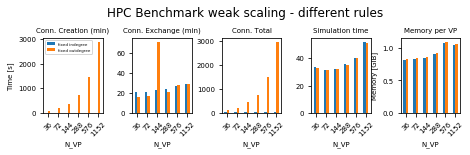

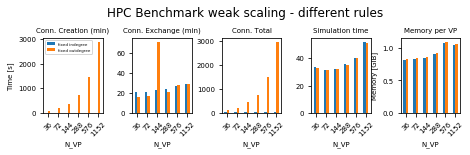

In [53]:
hpc_3_in = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_in.csv')
hpc_3_in['Case'] = ['fixed indegree']*len(hpc_3_in)

hpc_3_out = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_out.csv')
hpc_3_out['Case'] = ['fixed outdegree']*len(hpc_3_out)

hpc_rules = pd.concat([hpc_3_in, hpc_3_out])


hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules_p = plot_compare(hpc_rules, 'figures/hpc_benchmark_weak_scaling_rules.pdf', legend_loc='upper left',
                           title='HPC Benchmark weak scaling - different rules')

hpc_rules_p = plot_compare(hpc_rules, 'figures/hpc_benchmark_weak_scaling_rules.svg', legend_loc='upper left',
                           title='HPC Benchmark weak scaling - different rules')

### Population model

Conn. Creation (min)                                                  \
Case            NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old   
N_VP                                                                        
36              71.352708            57.778814                  57.905697   
72             100.998181            69.362128                  69.335492   
144            158.170904            90.439362                  89.550997   
288            263.136210           132.407036                 130.736555   
576                   NaN                  NaN                        NaN   
1152                  NaN                  NaN                        NaN   

     Conn. Exchange (min)                                                  \
Case            NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old   
N_VP                                                                        
36              46.780410            76.824877                  45.578337   
72              48.349137            77.148675                  47.704243   
144             50.818773            81.855925                  51.191208   
288             59.571098            90.679201                  61.675069   
576                   NaN                  NaN                        NaN   
1152                  NaN                  NaN                        NaN   

     Conn. Total                                                  \
Case   NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old   
N_VP                                                               
36    122.697226           134.889175                 113.009834   
72    153.851235           147.075606                 126.176039   
144   214.495860           174.418358                 149.590930   
288   329.935652           230.149506                 206.636241   
576          NaN                  NaN                        NaN   
1152         NaN                  NaN                        NaN   

     Memory per VP                                                    T_nrns  \
Case     NEST 2.20 NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old NEST 2.20   
N_VP                                                                           
36        3.437732             3.533765                   3.456075  0.379886   
72        3.508745             3.639517                   3.561793  0.827344   
144       3.737454             3.837888                   3.781858  0.636039   
288       3.519215             3.632609                   3.554878  0.951179   
576            NaN                  NaN                        NaN       NaN   
1152           NaN                  NaN                        NaN       NaN   

                                                      
Case NEST 3.0 (630a97265) NEST 3.0 (630a97265) - old  
N_VP                                                  
36               0.220223                   0.131594  
72               0.237714                   0.075080  
144              0.485208                   0.106480  
288              0.393870                   0.170175  
576                   NaN                        NaN  
1152                  NaN                        NaN

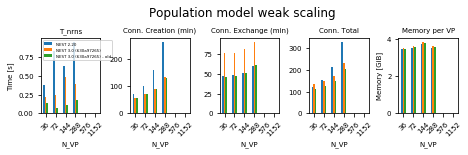

In [43]:
population_2_20 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in.csv')
population_2_20['Case'] = ['NEST 2.20'] * len(population_2_20)
population_3 = pd.read_csv('results/population_model_3_0_630a97265_daint_in.csv')
population_3['Case'] = ['NEST 3.0 (630a97265)'] * len(population_3)

population_3_old = pd.read_csv('results/population_model_3_0_47a9175e4_daint_in.csv')
population_3_old['Case'] = ['NEST 3.0 (630a97265) - old'] * len(population_3_old)

population = pd.concat([population_2_20, population_3, population_3_old])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/population_model_weak_scaling.pdf',
                            ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                             'Memory per VP'],
                            plot_T_sim=False, legend_loc='upper left',
                            title='Population model weak scaling')

population_p

### Population model - start with scale=4

Conn. Creation (min)                                                  \
Case            NEST 2.20 NEST 3.0 (47a9175e4) - old NEST 3.0 (a641eec1e)   
N_VP                                                                        
36              45.332983                  36.955057            38.884278   
72              80.451655                  55.495401            57.840276   
144            126.068755                  72.194067            74.970166   
288            210.201287                 104.732111           109.353257   
576            396.802894                 173.740939           180.889146   
1152           763.592566                 309.285594           322.193618   

                                 Conn. Exchange (min)  \
Case NEST 3.0 (d4d1b3f59 inline)            NEST 2.20   
N_VP                                                    
36                     38.096825            29.345186   
72                     57.296716            38.265924   
144                    74.859631            41.133215   
288                   110.317330            48.099635   
576                   183.693664            64.053706   
1152                  327.390571            94.555175   

                                                      \
Case NEST 3.0 (47a9175e4) - old NEST 3.0 (a641eec1e)   
N_VP                                                   
36                    29.071780            49.334207   
72                    37.857497            62.689724   
144                   41.669640            63.680735   
288                   47.426490            64.819529   
576                   64.363408            67.171092   
1152                  92.295056            81.457428   

                                 Conn. Total                             \
Case NEST 3.0 (d4d1b3f59 inline)   NEST 2.20 NEST 3.0 (47a9175e4) - old   
N_VP                                                                      
36                     41.498178   77.963455                  71.925418   
72                     53.665633  122.550333                 100.845343   
144                    53.371106  171.757519                 122.426312   
288                    55.716680  264.531648                 160.873778   
576                    57.972258  471.992790                 247.792988   
1152                   73.182611  880.145318                 424.864993   

                                                      Memory per VP  \
Case NEST 3.0 (a641eec1e) NEST 3.0 (d4d1b3f59 inline)     NEST 2.20   
N_VP                                                                  
36              92.642382                   82.099430      2.222359   
72             125.366041                  113.747868      2.927504   
144            144.761837                  132.667625      3.003872   
288            181.341080                  169.338060      2.939354   
576            257.050527                  249.800798      2.998736   
1152           417.533932                  419.609468      3.081466   

                                                      \
Case NEST 3.0 (47a9175e4) - old NEST 3.0 (a641eec1e)   
N_VP                                                   
36                     2.236429             2.319485   
72                     2.953619             3.008531   
144                    3.036972             3.091884   
288                    3.031440             3.088916   
576                    3.031835             3.089310   
1152                   3.032537             3.090094   

                                  
Case NEST 3.0 (d4d1b3f59 inline)  
N_VP                              
36                      2.323322  
72                      3.021238  
144                     3.104591  
288                     3.099019  
576                     3.102018  
1152                    3.102760

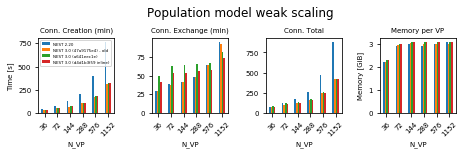

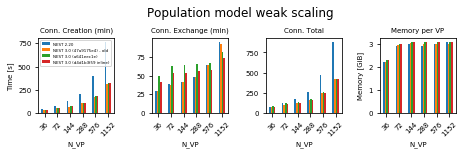

In [18]:
population_s4_220 = pd.read_csv('results/population_model_2_20_37722d5e3_daint_in_scale4.csv')
population_s4_220['Case'] = ['NEST 2.20'] * len(population_s4_220)
#population_s4_3 = pd.read_csv('results/population_model_3_0_630a97265_daint_in_scale4.csv')
#population_s4_3['Case'] = ['NEST 3.0 (630a97265)'] * len(population_s4_3)

population_s4_3_d4_in = pd.read_csv('results/population_model_3_0_d4d1b3f59_inline_daint_in_scale4.csv')
population_s4_3_d4_in['Case'] = ['NEST 3.0 (d4d1b3f59 inline)'] * len(population_s4_3_d4_in)
#population_s4_3_d4 = pd.read_csv('results/population_model_3_0_d4d1b3f59_daint_in_scale4.csv')
#population_s4_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(population_s4_3_d4)

population_s4_3_a6 = pd.read_csv('results/population_model_3_0_a641eec1e_daint_in_scale4.csv')
population_s4_3_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(population_s4_3_a6)

population_s4_3_old = pd.read_csv('results/population_model_3_0_47a9175e4_daint_in_scale4.csv')
population_s4_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(population_s4_3_old)

population_s4 = pd.concat([population_s4_220, population_s4_3_old, population_s4_3_a6, population_s4_3_d4_in])

population_s4 = calculate_T_conn_and_memory(population_s4)
population_s4_p = plot_compare(population_s4, 'figures/population_model_weak_scaling_scale4.pdf',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p = plot_compare(population_s4, 'figures/population_model_weak_scaling_scale4.svg',
                               ['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                'Memory per VP'],
                               plot_T_sim=False, legend_loc='upper left',
                               title='Population model weak scaling')

population_s4_p

### Population model - `fixed_outdegree`

0     382.215893
1     661.518434
2    1210.709612
3    2270.137045
4    4397.411327
5            NaN
0     517.505644
1     926.714142
2    1740.919693
3    3344.155159
4            NaN
5            NaN
Name: T_conns_min, dtype: float64
0     396.630207
1     676.281729
2    1266.915778
3    2377.381401
4    5143.177032
5            NaN
0     657.270283
1     945.149023
2    1794.366704
3    3448.692000
4            NaN
5            NaN
Name: T_conns_max, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: T_ini_min, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: T_ini_max, dtype: float64


TypeError: Empty 'DataFrame': no numeric data to plot

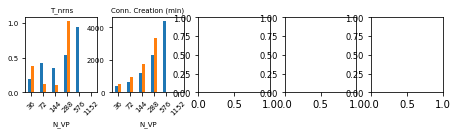

In [35]:
population_out_m = pd.read_csv('results/population_model_02a44ba55_daint_out.csv')
population_out_m['Case'] = ['Master (02a44ba55)'] * len(population_out_m)
population_out_3 = pd.read_csv('results/population_model_3_0_47a9175e4_daint_out.csv')
population_out_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(population_out_3)

population_out = pd.concat([population_out_m, population_out_3])

population_out = calculate_T_conn_and_memory(population_out)

print(population_out['T_conns_min'])
print(population_out['T_conns_max'])
print(population_out['T_ini_min'])
print(population_out['T_ini_max'])
population_out_p = plot_compare(population_out, 'figures/population_model_out_weak_scaling.pdf',
                                ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                                 'Memory per VP'],
                                plot_T_sim=False, legend_loc='upper left')

population_out_p

### Multi-Area Model

0    4.504810e+06
1    7.774718e+06
2    2.336961e+07
3    2.818219e+06
4             NaN
5             NaN
0    6.036307e+07
1    1.196042e+08
2    2.429526e+08
3    4.869240e+08
4    5.553407e+06
5    1.918936e+09
0    1.341351e+07
1             NaN
2    2.924561e+06
3    5.567620e+06
4             NaN
5    2.205080e+07
Name: N_spks_sum, dtype: float64


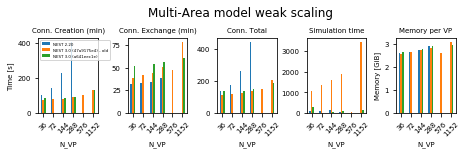

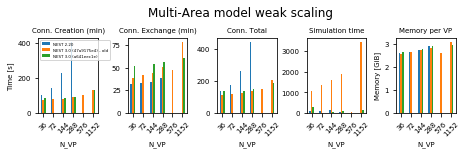

In [18]:
MAM_220 = pd.read_csv('results/multi-area_model_2_20_new_daint.csv')
MAM_220['Case'] = ['NEST 2.20'] * len(MAM_220)
# MAM_3 = pd.read_csv('results/multi-area_model_3_0_0a6bac389_daint.csv')
# MAM_3['Case'] = ['NEST 3.0 (0a6bac389)'] * len(MAM_3)

# MAM_3_d4_in = pd.read_csv('results/multi-area_model_3_0_d4d1b3f59_daint_inline.csv')
# MAM_3_d4_in['Case'] = ['NEST 3.0 (d4d1b3f59 inline)'] * len(MAM_3_d4_in)
# MAM_3_d4 = pd.read_csv('results/multi-area_model_3_0_d4d1b3f59_daint.csv')
# MAM_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(MAM_3_d4)

MAM_a6 = pd.read_csv('results/multi-area_model_3_0_a641eec1e_daint.csv')
MAM_a6['Case'] = ['NEST 3.0 (a641eec1e)'] * len(MAM_a6)

MAM_3_old = pd.read_csv('results/multi-area_model_3_0_47a9175e4_daint.csv')
MAM_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(MAM_3_old)

MAM = pd.concat([MAM_220, MAM_3_old, MAM_a6])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.pdf', legend_loc='upper left',
                     title='Multi-Area model weak scaling')
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.svg', legend_loc='upper left',
                     title='Multi-Area model weak scaling')

print(MAM['N_spks_sum'])
# print(MAM['N_nrns'])
# print(MAM['N_conns_sum'])

Case,NEST 2.20,NEST 3.0 (0a6bac389)
Conn. Total,725.681712,170.584532
Simulation time,219.553580,216.758883


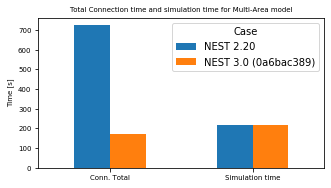

In [17]:
if True:
    MAM_full_220 = pd.read_csv('results/multi-area_model_2_20_daint_full.csv')
    MAM_full_220['Case'] = ['NEST 2.20'] * len(MAM_full_220)
    MAM_full_3 = pd.read_csv('results/multi-area_model_3_0_0a6bac389_daint_full.csv')
    MAM_full_3['Case'] = ['NEST 3.0 (0a6bac389)'] * len(MAM_full_3)

    MAM_full = pd.concat([MAM_full_220, MAM_full_3])

    MAM_full['T_conns_min'] = MAM_full['T_network_global_min'] + MAM_full['T_connect_min']
    MAM_full['T_conns_max'] = MAM_full['T_network_global_max'] + MAM_full['T_connect_max']

    MAM_full= calculate_T_conn_and_memory(MAM_full)
else:
    MAM_full = MAM[MAM['NUMBER_OF_NODES']==16]

MAM_full['Simulation time'] = MAM_full['T_sim']

values = ['Conn. Total', 'Simulation time']

df_p = pd.pivot_table(MAM_full, columns='Case', values=values)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(cm2inch(13),cm2inch(7)))
df_p.plot(kind='bar', ax = axes, title='Total Connection time and simulation time for Multi-Area model',
          fontsize=fontsize_axis, rot=0)
axes.set_ylabel('Time [s]')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.pdf", bbox_inches='tight')

#fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.svg", bbox_inches='tight')

df_p

### Topology model

NB! This is not 4x4!

,git,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,count,T_nrns,T_conns_max,T_conns_min,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_nrns,N_conns_sum,Case,N_VP
0,NaN,1,6,6,6,36,1,NaN,3.348829,113.986795,113.986485,7961280.0,45697728.0,50453304.0,50453304.0,661029.0,6.067075e+08,Master (00e0d3cc8),36
1,NaN,2,6,6,12,72,2,NaN,7.271655,256.673565,256.665625,17810996.0,148293172.0,155750180.0,155750180.0,1321997.0,2.422275e+09,Master (00e0d3cc8),72
2,NaN,4,6,6,24,144,4,NaN,12.448437,501.132981,501.091950,46734868.0,538326548.0,553793524.0,553793524.0,2643933.0,9.680283e+09,Master (00e0d3cc8),144
3,NaN,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Master (00e0d3cc8),288
0,NaN,1,6,6,6,36,1,NaN,3.769301,90.976650,90.976173,9456928.0,40725024.0,47372952.0,47372952.0,660968.0,6.067161e+08,NEST 3.0 (47a9175e4),36
1,NaN,2,6,6,12,72,2,NaN,7.491998,267.703830,267.682693,21097972.0,151196660.0,159261924.0,159261924.0,1321936.0,2.422389e+09,NEST 3.0 (47a9175e4),72
2,NaN,4,6,6,24,144,4,NaN,13.790759,631.175217,631.108117,50650516.0,569217940.0,579097972.0,579097972.0,2643872.0,9.680669e+09,NEST 3.0 (47a9175e4),144
3,NaN,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NEST 3.0 (47a9175e4),288


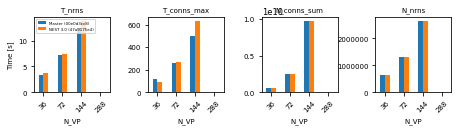

In [13]:
topology_m = pd.read_csv('results/topology_model_00e0d3cc8_daint.csv')
topology_m['Case'] = ['Master (00e0d3cc8)'] * len(topology_m)
topology_3 = pd.read_csv('results/topology_model_3_0_47a9175e4_daint.csv')
topology_3['Case'] = ['NEST 3.0 (47a9175e4)'] * len(topology_3)

topology = pd.concat([topology_m, topology_3])

#topology = calculate_T_conn_and_memory(topology)

topology['N_VP'] = topology['NUM_VPS']

topology_p = plot_compare(topology, 'figures/topology_model_weak_scaling.pdf',
                          values=['T_nrns','T_conns_max', 'N_conns_sum', 'N_nrns'],
                          plot_T_sim=False, legend_loc='upper left')

topology

### 4x4 Mesocircuit model

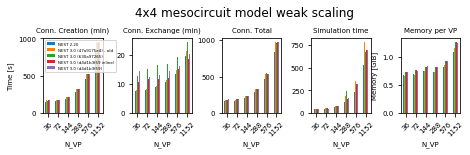

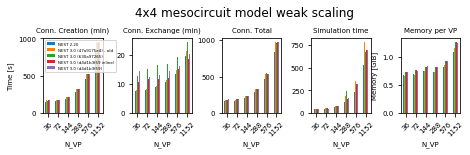

In [38]:
meso_2_20 = pd.read_csv('results/4x4_mesocircuit_2_20_37722d5e3_daint.csv')
meso_2_20['Case'] = ['NEST 2.20'] * len(meso_2_20)
meso_3 = pd.read_csv('results/4x4_mesocircuit_3_0_630a97265_daint.csv')
meso_3['Case'] = ['NEST 3.0 (630a97265)'] * len(meso_3)

meso_3_d4 = pd.read_csv('results/4x4_mesocircuit_3_0_d4d1b3f59_daint.csv')
meso_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(meso_3_d4)
meso_3_d4_in = pd.read_csv('results/4x4_mesocircuit_3_0_d4d1b3f59_inline_daint.csv')
meso_3_d4_in['Case'] = ['NEST 3.0 (d4d1b3f59 inline)'] * len(meso_3_d4_in)

meso_3_old = pd.read_csv('results/4x4_mesocircuit_3_0_47a9175e4_daint.csv')
meso_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(meso_3_old)

meso = pd.concat([meso_2_20, meso_3, meso_3_old, meso_3_d4, meso_3_d4_in])

meso = calculate_T_conn_and_memory(meso)
meso
meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.pdf',
                      #values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                      #        'N_conns_sum', 'N_nrns'],
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')

meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.svg',
                      legend_loc='upper left',
                      title='4x4 mesocircuit model weak scaling')

# print(meso['N_nrns'])
# print(meso['N_conns_sum'])

### Jakob benchmark
See https://github.com/nest/nest-simulator/pull/1380

0     0.00
1     0.00
2     0.01
3     0.02
4     0.00
5     0.00
6     0.00
7     0.00
0     0.01
1     0.01
2     0.02
3     0.04
4     0.07
5     0.14
6     0.27
7     0.54
0     0.16
1     0.31
2     0.63
3     1.27
4     2.55
5     5.09
6    10.26
7    20.46
0     0.19
1     0.39
2     0.79
3     1.59
4     3.20
5     6.41
6    12.80
7    25.59
Name: Conn. Creation (min), dtype: float64 0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: N_spks_sum, dtype: int64 0      590
1     1175
2     2345
3     4685
4     9365
5    18725
6    37445
7    74885
0      588
1     1173
2     2343
3     4683
4     9363
5    18723
6    37443
7    74883
0      590
1     1175
2     2345
3     4685
4     9365
5    18725
6    37445
7    74885
0      588
1     1173
2     2343
3     4683
4     9363
5    18723
6    37443
7    7488

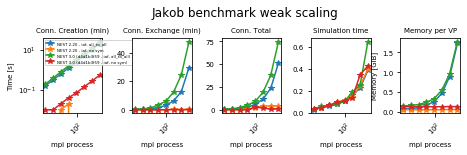

In [59]:
jakob_2_20 = pd.read_csv('results/jakob_bench_2_20_37722d5e3_daint.csv')
jakob_2_20['Case'] = ['NEST 2.20'] * len(jakob_2_20)

jakob_3 = pd.read_csv('results/jakob_bench_3_0_d4d1b3f59_daint.csv')
jakob_3['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(jakob_3)

# jakob_3_no_conv = pd.read_csv('results/jakob_bench_3_0_d4d1b3f59_no_cvnodecoll_daint.csv')
# jakob_3_no_conv['Case'] = ['NEST 3.0 (d4d1b3f59 - no cvnodecollection)'] * len(jakob_3_no_conv)

jakob_2_20_more_n = pd.read_csv('results/jakob_bench_2_20_37722d5e3_more_neurons_daint.csv')
jakob_2_20_more_n['Case'] = ['NEST 2.20 - more neurons'] * len(jakob_2_20_more_n)
jakob_3_more_n = pd.read_csv('results/jakob_bench_3_0_d4d1b3f59_more_neurons_daint.csv')
jakob_3_more_n['Case'] = ['NEST 3.0 (d4d1b3f59 - more neurons)'] * len(jakob_3_more_n)

jakob_2_20_iaf_no_sym = pd.read_csv('results/jakob_bench_2_20_37722d5e3_iaf_no_sym_daint.csv')
jakob_2_20_iaf_no_sym['Case'] = ['NEST 2.20 - iaf, no sym'] * len(jakob_2_20_iaf_no_sym)
jakob_3_iaf_no_sym = pd.read_csv('results/jakob_bench_3_0_d4d1b3f59_iaf_no_sym_daint.csv')
jakob_3_iaf_no_sym['Case'] = ['NEST 3.0 (d4d1b3f59 - iaf, no sym)'] * len(jakob_3_iaf_no_sym)

jakob_2_20_iaf_all = pd.read_csv('results/jakob_bench_2_20_37722d5e3_iaf_all_to_all_daint.csv')
jakob_2_20_iaf_all['Case'] = ['NEST 2.20 - iaf, all_to_all'] * len(jakob_2_20_iaf_all)
jakob_3_iaf_all = pd.read_csv('results/jakob_bench_3_0_d4d1b3f59_iaf_all_to_all_daint.csv')
jakob_3_iaf_all['Case'] = ['NEST 3.0 (d4d1b3f59 - iaf, all_to_all)'] * len(jakob_3_iaf_all)


jakob = pd.concat([#jakob_2_20, jakob_3,# jakob_2_20_more_n, jakob_3_more_n,
                   jakob_2_20_iaf_no_sym, jakob_3_iaf_no_sym,
                   jakob_2_20_iaf_all, jakob_3_iaf_all])

jakob = calculate_T_conn_and_memory(jakob)
#jakob_p = plot_compare(jakob, 'figures/jacob_benchmark_weak_scaling.pdf',
#                       legend_loc='upper left',
#                       title='Jakob benchmark weak scaling')

#name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
#                color=None, plot_T_sim=True, plot_kind='bar', title=''

jakob['Simulation time'] = jakob['T_sim']
jakob['mpi process'] = jakob['num_tasks']
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Simulation time', 'Memory per VP']
index='mpi process'

jakob_p = pd.pivot_table(jakob, index=index, columns='Case', values=values)

# Make subplots
fig, axes = plt.subplots(nrows=1, ncols=len(values))

for indx, val_name in enumerate(values):
    logy = False
    if val_name == 'Conn. Creation (min)':
        logy = True
    jakob_p[val_name].plot(kind='line', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=45,
                           logy=logy, logx=True, style=['-*'] * len(jakob['Case']), legend=False, color=None)#,
                           #xticks=[1e0, 1e1, 1e2, 1e3])
axes[0].legend(fontsize=fontsize_legends, loc='upper left')

plt.subplots_adjust(wspace=0.5)

# y-axis labels
axes[0].set_ylabel('Time [s]')

# Memory is last entry in values
axes[len(values) - 1].set_ylabel('Memory [GiB]')

# x-axis labels
for ax in axes:
    ax.set_xlabel(index)

fig.suptitle('Jakob benchmark weak scaling', y=1.2)
            
fig = plt.gcf()
fig.savefig('figures/jacob_benchmark_weak_scaling_2.pdf', bbox_inches='tight')

print(jakob['Conn. Creation (min)'], jakob['N_spks_sum'], jakob['N_nrns'], jakob['N_conns_sum'])

### IPPEN

In [33]:
def ippen_plot(df, name, values, legend_loc='upper right', title=''):
    
    fontsize = 10
    index = 'N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    fig, axes = plt.subplots(nrows=len(values), ncols=1, figsize=(cm2inch(19),cm2inch(29)))
    if len(values) == 1:
        axes = [axes]

    for indx, val_name in enumerate(values):
        logy=False
        if val_name == 'Simulation Time [s]':
            logy=True
        if val_name == 'VSize_sum':
            df_p[val_name][::5].plot(kind='bar', ax = axes[indx],
                                fontsize=fontsize, logy=logy,
                                legend=False)
        else:
            df_p[val_name].plot(kind='line', style=['-*'] * len(df['Case']), ax = axes[indx],
                                fontsize=fontsize, logy=logy,
                                legend=False)
        axes[indx].set_ylabel(val_name, fontsize=fontsize)
    axes[0].legend(fontsize=fontsize, loc=legend_loc)
    
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[2].set_xlabel('')
    axes[3].set_xlabel('Virtual Processes', fontsize=fontsize)

    plt.subplots_adjust(wspace=0.5)
            
    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

Conn. Creation (min) [s]                                      \
Case      6ec58071f - threads NEST 2.20 - mpi NEST 2.20 - threads   
N_VP                                                                
1                       12.27           12.61               12.60   
2                        7.01            6.57                7.17   
3                        7.36            4.34                7.54   
4                        6.46            3.27                6.71   
5                        5.65             NaN                5.66   
6                        4.89            2.24                4.99   
7                        4.47            1.94                4.57   
8                        4.02            1.76                4.12   
9                        3.83            1.59                3.98   
10                       3.52            1.48                3.61   
11                       3.40            1.35                3.47   
12                       3.30            1.24                3.42   
13                       3.16            1.18                3.15   
14                       2.94            1.13                3.01   
15                       2.89            1.04                2.94   
16                       2.76            1.00                2.81   
17                       2.66            0.96                2.76   
18                       2.54            0.89                2.58   
19                       2.45            0.87                2.48   
20                       2.35            0.81                2.40   
21                       2.31            0.77                2.34   
22                       2.21            0.74                2.22   
23                       2.14            0.71                2.17   
24                       2.08            0.67                2.09   
25                       2.03            0.65                2.05   
26                       1.95            0.63                1.98   
27                       1.91            0.61                1.95   
28                       1.86            0.57                1.88   
29                       1.82            0.56                1.85   
30                       1.75            0.54                1.78   
31                       1.72            0.53                1.74   
32                       1.66            0.51                1.68   
33                       1.62            0.50                1.66   
34                       1.58            0.49                1.60   
35                       1.56            0.51                1.58   
36                       1.52            0.45                1.53   

                                Conn. Exchange (min) [s]                  \
Case NEST 3.0 (630a97265) - mpi      6ec58071f - threads NEST 2.20 - mpi   
N_VP                                                                       
1                         13.20                    11.50           11.54   
2                          7.30                     6.83            5.72   
3                          4.94                     6.19            3.96   
4                          3.71                     5.58            2.98   
5                          2.97                     4.99             NaN   
6                          2.61                     4.66            2.10   
7                          2.26                     4.40            1.84   
8                          2.05                     4.16            1.61   
9                          1.81                     3.95            1.49   
10                         1.66                     3.83            1.37   
11                         1.54                     3.71            1.29   
12                         1.42                     3.71            1.17   
13                         1.33                     3.54            1.12   
14                         1.27                     3.67            1.07   
15                   

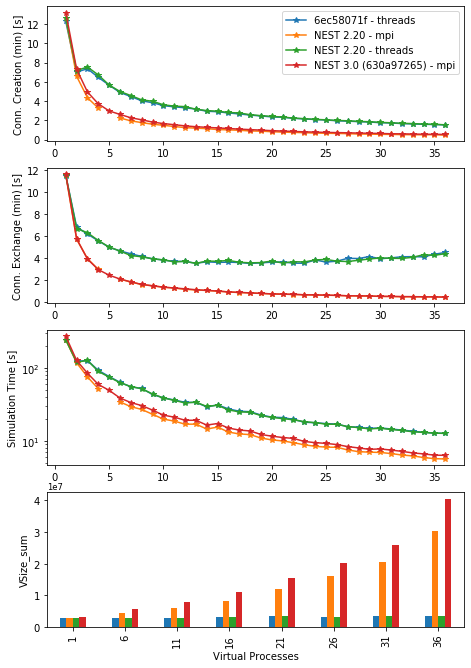

In [34]:
ippen_thread_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_ippen_thread.csv')
ippen_mpi_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_ippen_mpi.csv')
ippen_thread_220['Case'] = ['NEST 2.20 - threads'] * len(ippen_thread_220)
ippen_mpi_220['Case'] = ['NEST 2.20 - mpi'] * len(ippen_mpi_220)

ippen_thread_6ec58071f = pd.read_csv('results/hpc_benchmark_6ec58071f_daint_ippen_thread.csv')
ippen_thread_6ec58071f['Case'] = ['6ec58071f - threads'] * len(ippen_thread_6ec58071f)

ippen_thread_3 = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_ippen_thread.csv')
ippen_mpi_3 = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_ippen_mpi.csv')
ippen_thread_3['Case'] = ['NEST 3.0 (630a97265) - threads'] * len(ippen_thread_3)
ippen_mpi_3['Case'] = ['NEST 3.0 (630a97265) - mpi'] * len(ippen_mpi_3)

ippen = pd.concat([ippen_thread_220, ippen_mpi_220, ippen_thread_6ec58071f, ippen_thread_3, ippen_mpi_3])
ippen = pd.concat([ippen_thread_220, ippen_mpi_220, ippen_thread_6ec58071f, ippen_mpi_3])

ippen['N_VP'] = ippen['NUMBER_OF_NODES'] * ippen['TASKS_PER_NODE'] * ippen['THREADS_PER_TASK']

ippen = calculate_T_conn_and_memory(ippen)

ippen['Simulation Time [s]'] = ippen['T_sim']
ippen['Conn. Exchange (min) [s]'] = ippen['T_ini_min']
ippen['Conn. Creation (min) [s]'] = ippen['T_conns_min']

ippen_p = ippen_plot(ippen, 'figures/ippen_benchmark.pdf',
                     values=['Conn. Creation (min) [s]', 'Conn. Exchange (min) [s]',
                             'Simulation Time [s]', 'VSize_sum'])

ippen_p

## Benchmarks with strong scaling

### HPC Benchmark

Conn. Creation (min)                       \
Case                 NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                             
6                         0.61                 0.69   
12                        0.30                 0.35   
24                        0.15                 0.18   
48                        0.08                 0.09   
96                        0.04                 0.05   
192                       0.02                 0.03   
384                       0.01                 0.02   
768                       0.00                 0.02   

                                                            \
Case      NEST 3.0 (d4d1b3f59 inline) NEST 3.0 (d4d1b3f59)   
num_tasks                                                    
6                                0.74                 0.74   
12                               0.38                 0.38   
24                               0.19                 0.19   
48                               0.10                 0.10   
96                               0.06                 0.06   
192                              0.03                 0.03   
384                              0.02                 0.02   
768                              0.02                 0.02   

          Conn. Exchange (min)                       \
Case                 NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                             
6                         0.68                 1.10   
12                        0.47                 0.70   
24                        0.31                 0.42   
48                        0.29                 0.37   
96                        0.16                 0.15   
192                       0.18                 0.21   
384                       0.20                 0.25   
768                       0.18                 0.23   

                                                           Conn. Total  \
Case      NEST 3.0 (d4d1b3f59 inline) NEST 3.0 (d4d1b3f59)   NEST 2.20   
num_tasks                                                                
6                                1.04                 1.18        1.48   
12                               0.60                 0.69        0.80   
24                               0.34                 0.38        0.49   
48                               0.30                 0.35        0.82   
96                               0.12                 0.13        0.61   
192                              0.49                 0.23        0.88   
384                              0.24                 0.10        0.94   
768                              0.17                 0.19        0.71   

                                                            \
Case      NEST 3.0 (630a97265) NEST 3.0 (d4d1b3f59 inline)   
num_tasks                                                    
6                         1.89                        2.05   
12                        1.10                        1.11   
24                        0.63                        0.61   
48                        0.48                        0.44   
96                        0.22                        0.23   
192                       0.56                        1.11   
384                       0.60                        0.67   
768                       0.87                        0.53   

                               Memory per task                       \
Case      NEST 3.0 (d4d1b3f59)       NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                                             
6                         2.19        0.635518             1.103779   
12                        1.20        0.540298             1.010837   
24                        0.65        0.461600             0.933848   
48                        0.52        0.760461             1.120130   
96                        0.21        0.372274             0.842503   
192                       0.60        0.346288   

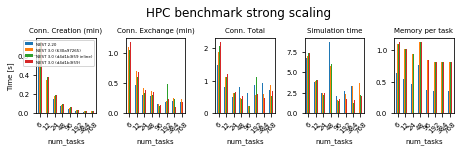

In [29]:
hpc_strong_220 = pd.read_csv('results/hpc_benchmark_2_20_daint_strong_scaling.csv')
hpc_strong_220['Case'] = ['NEST 2.20'] * len(hpc_strong_220)
hpc_strong_3 = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_strong_scaling.csv')
hpc_strong_3['Case'] = ['NEST 3.0 (630a97265)'] * len(hpc_strong_3)

hpc_strong_3_d4_inline = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_inline_daint_strong_scaling.csv')
hpc_strong_3_d4_inline['Case'] = ['NEST 3.0 (d4d1b3f59 inline)'] * len(hpc_strong_3_d4_inline)
hpc_strong_3_d4 = pd.read_csv('results/hpc_benchmark_3_0_d4d1b3f59_daint_strong_scaling.csv')
hpc_strong_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(hpc_strong_3_d4)

hpc_strong = pd.concat([hpc_strong_220, hpc_strong_3, hpc_strong_3_d4_inline, hpc_strong_3_d4])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
hpc_strong['Memory per task'] = (hpc_strong['VSize_sum']/hpc_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hpc_strong_p = plot_compare(hpc_strong, 'figures/hpc_benchmark_strong_scaling.pdf', values=values, index='num_tasks',
                            legend_loc='upper right',
                            title='HPC benchmark strong scaling')

hpc_strong_p

### Population model

Conn. Creation (min)                       \
Case                 NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                             
6                    71.324164            57.804584   
12                   50.129546            34.527905   
24                   38.904915            22.543471   
48                   33.418015            16.547482   
96                   30.753708            13.520983   
192                  29.517396            12.033568   
384                  28.974048            11.228554   
768                  27.407290            10.770785   

                                                            \
Case      NEST 3.0 (d4d1b3f59 inline) NEST 3.0 (d4d1b3f59)   
num_tasks                                                    
6                                 NaN                  NaN   
12                          71.752070            71.659769   
24                          46.911446            46.819822   
48                          34.489738            34.505664   
96                          28.665369            28.801075   
192                         25.565596            25.651576   
384                         23.813173            23.934190   
768                         22.674821            22.823735   

          Conn. Exchange (min)                       \
Case                 NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                             
6                    47.624212            78.622077   
12                   23.524206            38.825472   
24                   12.937575            20.397037   
48                    7.872210            11.679158   
96                    4.671457             7.211241   
192                   2.990739             4.538679   
384                   1.844977             2.479983   
768                   1.190094             1.414014   

                                                           Conn. Total  \
Case      NEST 3.0 (d4d1b3f59 inline) NEST 3.0 (d4d1b3f59)   NEST 2.20   
num_tasks                                                                
6                                 NaN                  NaN  123.471093   
12                          68.798637            75.602642   76.196952   
24                          34.381158            38.112961   53.271152   
48                          17.977131            19.759765   42.225837   
96                           9.541015            10.829389   36.140110   
192                          5.290884             6.057964   33.340712   
384                          4.514681             5.765935   31.634172   
768                          2.526086             2.608972   29.502074   

                                                            \
Case      NEST 3.0 (630a97265) NEST 3.0 (d4d1b3f59 inline)   
num_tasks                                                    
6                   136.819173                         NaN   
12                   73.655930                  144.009436   
24                   43.176714                   83.960336   
48                   28.733300                   54.290787   
96                   21.247847                   39.463024   
192                  17.204961                   32.343364   
384                  14.198042                   29.901702   
768                  12.899132                   26.387862   

                               Memory per task                       \
Case      NEST 3.0 (d4d1b3f59)       NEST 2.20 NEST 3.0 (630a97265)   
num_tasks                                                             
6                          NaN       20.938893            21.202587   
12                  151.492076       11.013250            11.693613   
24                   86.777802        6.395530             6.945685   
48                   56.238982        3.788223             4.431476   
96                   41.285251        2.483136             3.305507   
192                  33.335833        1.937623   

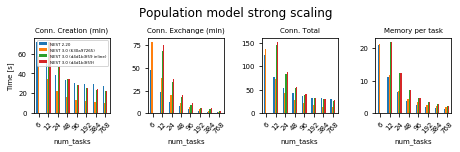

In [11]:
population_strong_220 = pd.read_csv('results/population_model_2_20_daint_strong_scaling_in.csv')
population_strong_220['Case'] = ['NEST 2.20'] * len(population_strong_220)
population_strong_3 = pd.read_csv('results/population_model_3_0_630a97265_daint_strong_scaling_in.csv')
population_strong_3['Case'] = ['NEST 3.0 (630a97265)'] * len(population_strong_3)

pop_strong_3_in = pd.read_csv('results/population_model_3_0_d4d1b3f59_inline_daint_strong_scaling_in.csv')
pop_strong_3_in['Case'] = ['NEST 3.0 (d4d1b3f59 inline)'] * len(pop_strong_3_in)
pop_strong_3 = pd.read_csv('results/population_model_3_0_d4d1b3f59_daint_strong_scaling_in.csv')
pop_strong_3['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(pop_strong_3)

population_strong = pd.concat([population_strong_220, population_strong_3, pop_strong_3_in, pop_strong_3])

population_strong = calculate_T_conn_and_memory(population_strong)
population_strong['Memory per task'] = (population_strong['VSize_sum']/population_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
population_strong_p = plot_compare(population_strong, 'figures/population_model_strong_scaling.pdf', values=values,
                                   index='num_tasks', plot_T_sim=False, legend_loc='upper right',
                                   title='Population model strong scaling')

population_strong_p

### Multi-Area Model

Conn. Creation (min)                       \
Case                 NEST 2.20 NEST 3.0 (0a6bac389)   
num_tasks                                             
192                 656.739572            79.676365   
288                 647.955257            71.899920   
384                        NaN            66.774317   
480                 642.865273            65.944416   
576                 642.099864                  NaN   
672                 640.462307                  NaN   
768                 640.647660                  NaN   

                                                                  \
Case      NEST 3.0 (47a9175e4) - old NEST 3.0 (d4d1b3f59 inline)   
num_tasks                                                          
192                        77.340813                         NaN   
288                        69.712029                   73.672791   
384                        66.715326                   69.840608   
480                        63.418275                   62.293664   
576                        63.423330                         NaN   
672                        59.374492                         NaN   
768                        58.556264                         NaN   

                               Conn. Exchange (min)                       \
Case      NEST 3.0 (d4d1b3f59)            NEST 2.20 NEST 3.0 (0a6bac389)   
num_tasks                                                                  
192                        NaN            27.460267            37.714782   
288                  72.471682            21.280975            28.383355   
384                  68.778757                  NaN            22.856739   
480                  66.550205            15.629361            19.666301   
576                        NaN            13.862626                  NaN   
672                        NaN            12.313328                  NaN   
768                        NaN            11.422459                  NaN   

                                                                  \
Case      NEST 3.0 (47a9175e4) - old NEST 3.0 (d4d1b3f59 inline)   
num_tasks                                                          
192                        28.159943                         NaN   
288                        22.065063                   20.215075   
384                        18.756371                   16.079397   
480                        16.319383                   13.727475   
576                        14.632541                         NaN   
672                        12.998581                         NaN   
768                        12.688724                         NaN   

                                ... Memory per task                       \
Case      NEST 3.0 (d4d1b3f59)  ...       NEST 2.20 NEST 3.0 (0a6bac389)   
num_tasks                       ...                                        
192                        NaN  ...       10.806041            10.289157   
288                  23.248026  ...        7.684051             7.329059   
384                  17.546150  ...             NaN             6.380819   
480                  15.389403  ...        5.874357             5.705365   
576                        NaN  ...        5.298488                  NaN   
672                        NaN  ...        4.921475                  NaN   
768                        NaN  ...        4.536059                  NaN   

                                                                  \
Case      NEST 3.0 (47a9175e4) - old NEST 3.0 (d4d1b3f59 inline)   
num_tasks                                                          
192                         9.842525                         NaN   
288                         6.936681                    7.329226   
384                         5.912887                    6.388420   
480                         5.223918                    5.703935   
576                         4.659974                         NaN   
672                         4.2

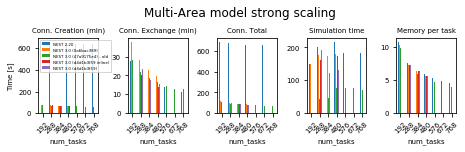

In [14]:
MAM_strong_220 = pd.read_csv('results/multi-area_model_2_20_daint_strong_scaling.csv')
MAM_strong_220['Case'] = ['NEST 2.20'] * len(MAM_strong_220)
MAM_strong_3 = pd.read_csv('results/multi-area_model_3_0_0a6bac389_daint_strong_scaling.csv')
MAM_strong_3['Case'] = ['NEST 3.0 (0a6bac389)'] * len(MAM_strong_3)
MAM_strong_3_d4_inline = pd.read_csv('results/multi-area_model_3_0_d4d1b3f59_daint_inline_strong_scaling.csv')
MAM_strong_3_d4_inline['Case'] = ['NEST 3.0 (d4d1b3f59 inline)'] * len(MAM_strong_3_d4_inline)

MAM_strong_3_d4 = pd.read_csv('results/multi-area_model_3_0_d4d1b3f59_daint_strong_scaling.csv')
MAM_strong_3_d4['Case'] = ['NEST 3.0 (d4d1b3f59)'] * len(MAM_strong_3_d4)

MAM_strong_3_old = pd.read_csv('results/multi-area_model_3_0_47a9175e4_daint_strong_scaling.csv')
MAM_strong_3_old['Case'] = ['NEST 3.0 (47a9175e4) - old'] * len(MAM_strong_3_old)

MAM_strong = pd.concat([MAM_strong_220, MAM_strong_3, MAM_strong_3_old, MAM_strong_3_d4_inline, MAM_strong_3_d4])

#print(MAM_strong)

MAM_strong = calculate_T_conn_and_memory(MAM_strong)
MAM_strong['Memory per task'] = (MAM_strong['VSize_sum']/MAM_strong['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
MAM_strong_p = plot_compare(MAM_strong, 'figures/multi-area_model_strong_scaling.pdf', values=values,
                            index='num_tasks', legend_loc='upper left',
                            title='Multi-Area model strong scaling')

MAM_strong_p

### Hill Tononi

Conn. Creation (min)                      Conn. Exchange (min)  \
Case                 NEST 2.20 NEST 3.0 (0a6bac389)            NEST 2.20   
num_tasks                                                                  
6                     3.369209             0.533420             0.344653   
12                    2.424937             0.323250             0.328508   
24                    1.863762             0.217795             0.278032   
48                    1.672143             0.170719             0.188323   
96                    1.589094             0.131994             0.149609   
192                   3.329755             0.125176             0.116746   
384                   1.560687             0.113853             0.129887   
768                   3.677774             0.108187             0.185456   

                               Conn. Total                       \
Case      NEST 3.0 (0a6bac389)   NEST 2.20 NEST 3.0 (0a6bac389)   
num_tasks                                                         
6                     0.439134    3.853066             1.006830   
12                    0.495574    2.901895             0.847532   
24                    0.429735    2.281637             0.703041   
48                    0.335961    2.019383             0.524091   
96                    0.222553    1.900187             0.379855   
192                   0.171311    3.600970             0.318269   
384                   0.277250    1.859231             1.152774   
768                   0.465883    4.055079             5.938115   

          Memory per task                      Simulation time  \
Case            NEST 2.20 NEST 3.0 (0a6bac389)       NEST 2.20   
num_tasks                                                        
6                1.346101             1.948261        1.442217   
12               1.298610             1.936536        0.866928   
24               1.256289             1.886118        0.613624   
48               1.120590             1.792625        0.398614   
96               1.015988             1.712402        0.357492   
192              1.013022             1.678068        0.308830   
384              1.042091             1.707746        0.286875   
768              1.038055             1.708427        0.325538   

                                
Case      NEST 3.0 (0a6bac389)  
num_tasks                       
6                     1.345068  
12                    0.793845  
24                    0.591356  
48                    0.460085  
96                    0.450733  
192                   0.368193  
384                   0.364980  
768                   0.740313

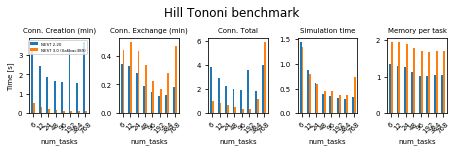

In [16]:
hill_tononi_220 = pd.read_csv('results/hill_tononi_2_20_daint.csv')
hill_tononi_220['Case'] = ['NEST 2.20'] * len(hill_tononi_220)
hill_tononi_3 = pd.read_csv('results/hill_tononi_3_0_0a6bac389_daint.csv')
hill_tononi_3['Case'] = ['NEST 3.0 (0a6bac389)'] * len(hill_tononi_3)

hill_tononi = pd.concat([hill_tononi_220, hill_tononi_3])

hill_tononi = calculate_T_conn_and_memory(hill_tononi)
hill_tononi['Memory per task'] = (hill_tononi['VSize_sum']/hill_tononi['num_tasks'])*1024/1024**3

values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per task']
hill_tononi_p = plot_compare(hill_tononi, 'figures/hill_tononi.pdf', values=values,
                             index='num_tasks', legend_loc='upper right',
                             title='Hill Tononi benchmark')

hill_tononi_p

## Compare versions

### num. nodes = 1,  num. threads = {1,3,6,9,18,36}, num. vps=36, SCALE=15

Conn. Creation (min)                                \
Case               NEST 2.14 NEST 2.16 NEST 2.18 NEST 2.20   
threads                                                      
1                      36.44     21.73     17.62     15.68   
3                      47.89     38.73     30.85     26.78   
6                      52.17     51.38     42.25     35.50   
9                      53.47     58.84     43.85     37.06   
18                     54.55     81.97     56.37     45.35   
36                     61.78    124.92     74.22     48.41   

                             Conn. Exchange (min)                      \
Case    NEST 3.0 (630a97265)            NEST 2.14 NEST 2.16 NEST 2.18   
threads                                                                 
1                      17.68                 0.62     18.79     11.87   
3                      30.76                 0.89     29.74     24.27   
6                      39.40                 0.96     35.99     32.64   
9                      40.83                 0.91     50.30     48.41   
18                     49.40                 1.38     66.25     68.98   
36                     55.37                 1.44     91.19     77.44   

                                               ...          Memory per VP  \
Case    NEST 2.20 NEST 3.0 (630a97265)         ...              NEST 2.14   
threads                                        ...                          
1           19.11                19.22         ...               2.312773   
3           29.40                35.80         ...               2.028328   
6           37.12                61.60         ...               1.983972   
9           45.18                66.78         ...               1.973401   
18          76.88                95.61         ...               1.963256   
36          98.88                98.32         ...               1.968212   

                                                           Simulation time  \
Case    NEST 2.16 NEST 2.18 NEST 2.20 NEST 3.0 (630a97265)       NEST 2.14   
threads                                                                      
1        5.072531  3.096897  3.112309             3.272301           85.58   
3        4.422857  2.269574  2.383765             2.418053          121.11   
6        4.332034  2.121685  2.123444             2.142378          128.85   
9        4.311907  2.100494  2.100258             2.118360          124.27   
18       4.293865  2.008091  2.041394             2.106842          130.37   
36       4.284930  1.989075  1.989507             2.062758          173.78   

                                                            
Case    NEST 2.16 NEST 2.18 NEST 2.20 NEST 3.0 (630a97265)  
threads                                                     
1           87.81     92.16     86.94                96.44  
3          128.25    126.82    122.40               129.81  
6          131.90    134.71    129.38               133.39  
9          135.43    136.02    130.46               133.42  
18         137.20    137.85    134.55               136.00  
36         187.95    204.53    196.16               198.60  

[6 rows x 25 columns]

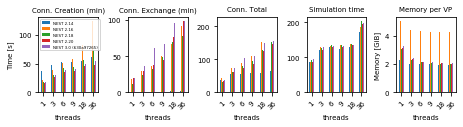

In [11]:
hpc_214 = pd.read_csv('../benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_214['Case'] = ['NEST 2.14']*len(hpc_214)
hpc_216 = pd.read_csv('../benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_216['Case'] = ['NEST 2.16']*len(hpc_216)
hpc_218 = pd.read_csv('../benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_218['Case'] = ['NEST 2.18']*len(hpc_218)
hpc_220 = pd.read_csv('results/hpc_benchmark_220_daint_threads_s15.csv')
hpc_220['Case'] = ['NEST 2.20']*len(hpc_220)
hpc_3   = pd.read_csv('results/hpc_benchmark_3_0__630a97265_daint_threads_s15.csv')
hpc_3['Case']   = ['NEST 3.0 (630a97265)']*len(hpc_3)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_220, hpc_3])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['threads'] = hpc_versions['THREADS_PER_TASK']
hpc_versions_p = plot_compare(hpc_versions, 'figures/hpc_different_versions.pdf', index='threads',
                              plot_T_sim=True, legend_loc='upper left',
                              rot=45)
hpc_versions_p

### num. threads = 1, num. nodes = {1, 2, 4, 8, 16, 32}, num. vps = 36, SCALE = 15

Conn. Creation (min)                                                     \
Case            NEST 2.14 NEST 2.16 NEST 2.18 NEST 2.20 NEST 3.0 (630a97265)   
N_VP                                                                           
36                  35.65     21.84     17.56     15.69                17.74   
72                  37.68     21.74     17.36     15.71                17.81   
144                 39.38     21.71     17.38     15.58                17.95   
288                 40.99     22.01     17.39     15.65                17.96   
576                 42.90     21.77     17.39     15.58                18.34   
1152                43.87     21.73     17.37     15.74                18.87   

     Conn. Exchange (min)                                                     \
Case            NEST 2.14 NEST 2.16 NEST 2.18 NEST 2.20 NEST 3.0 (630a97265)   
N_VP                                                                           
36                   0.60     18.22     11.78     19.03                18.27   
72                   0.63     18.84     11.78     18.71                19.41   
144                  0.58     22.50     12.36     20.56                21.24   
288                  0.67     22.05     13.03     21.87                22.63   
576                  0.90     24.56     15.09     24.21                24.66   
1152                 1.28     29.25     19.17     27.98                30.06   

             ...          Memory per VP                                \
Case         ...              NEST 2.14 NEST 2.16 NEST 2.18 NEST 2.20   
N_VP         ...                                                        
36           ...               2.312611  5.072531  3.096897  3.112309   
72           ...               2.327074  5.073708  3.107514  3.122925   
144          ...               2.707514  5.075892  3.109698  3.125110   
288          ...               3.149024  5.080248  3.114054  3.129465   
576          ...               3.144015  5.108859  3.578192  3.592993   
1152         ...               3.161597  5.123802  4.092529  4.110189   

                          Simulation time                                \
Case NEST 3.0 (630a97265)       NEST 2.14 NEST 2.16 NEST 2.18 NEST 2.20   
N_VP                                                                      
36               3.272301           82.85     88.38     90.13     87.90   
72               3.282917           84.19     87.63     90.85     89.87   
144              3.285102           87.78     92.08     95.31     94.95   
288              3.289458           97.88    105.33    105.49    106.69   
576              3.753239          110.44    119.03    128.16    123.07   
1152             4.273935          140.54    163.31    172.90    166.57   

                           
Case NEST 3.0 (630a97265)  
N_VP                       
36                  95.11  
72                  98.67  
144                103.46  
288                114.41  
576                135.24  
1152               187.92  

[6 rows x 25 columns]

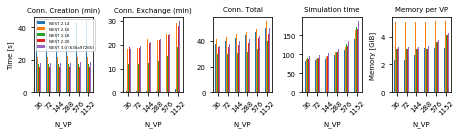

In [14]:
hpc_214_t1 = pd.read_csv('../benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214_t1['Case'] = ['NEST 2.14']*len(hpc_214_t1)
hpc_216_t1 = pd.read_csv('../benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216_t1['Case'] = ['NEST 2.16']*len(hpc_216_t1)
hpc_218_t1 = pd.read_csv('../benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218_t1['Case'] = ['NEST 2.18']*len(hpc_218_t1)
hpc_220_t1 = pd.read_csv('results/hpc_benchmar_220_daint_t1_s15.csv')
hpc_220_t1['Case']   = ['NEST 2.20']*len(hpc_220_t1)
hpc_3_t1   = pd.read_csv('results/hpc_benchmark_3_0_630a97265_daint_t1_s15.csv')
hpc_3_t1['Case']   = ['NEST 3.0 (630a97265)']*len(hpc_3_t1)

hpc_versions_t1 = pd.concat([hpc_214_t1, hpc_216_t1, hpc_218_t1, hpc_220_t1, hpc_3_t1])

hpc_versions_t1 = calculate_T_conn_and_memory(hpc_versions_t1)
hpc_versions_t1_p = plot_compare(hpc_versions_t1, 'figures/hpc_different_versions_t1.pdf', legend_loc='upper left',
                                 rot=45)

hpc_versions_t1_p